# Residual Attention Network - 164

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time, os, datetime
import PIL
import pandas as pd
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from tensorflow.keras.datasets import cifar10,cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,TensorBoard, LearningRateScheduler
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input,BatchNormalization,Conv2D,MaxPooling2D,Activation,AveragePooling2D,Flatten,Dropout,Dense

In [3]:
print("TF version: ",tf.__version__)
print("Keras version:",tf.keras.__version__)

TF version:  2.3.1
Keras version: 2.4.0


## Load CIFAR-10 Data

In [4]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [5]:
# devide into training & validation sets
n_validation = 10000

x_val   = x_train[-n_validation:]
y_val   = y_train[-n_validation:]
x_train = x_train[:-n_validation]
y_train = y_train[:-n_validation]

# Convert to binary class matrix
y_val   = to_categorical(y_val,   num_classes=10)
y_train = to_categorical(y_train, num_classes=10)
y_test  = to_categorical(y_test,  num_classes=10)


print('Training:   ',x_train.shape,y_train.shape)
print('Validation: ',x_val.shape,y_val.shape)
print('Test:       ',x_test.shape,y_test.shape)

Training:    (40000, 32, 32, 3) (40000, 10)
Validation:  (10000, 32, 32, 3) (10000, 10)
Test:        (10000, 32, 32, 3) (10000, 10)


## Data Augmentation

In [6]:
# define generators for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.10,
                                   height_shift_range=0.10,
                                   horizontal_flip=True,
                                   zoom_range = 0.10,
                                   rotation_range=20,
                                   shear_range = 0.10,)


val_datagen = ImageDataGenerator(rescale=1./255,)

test_datagen = ImageDataGenerator(rescale=1./255,)

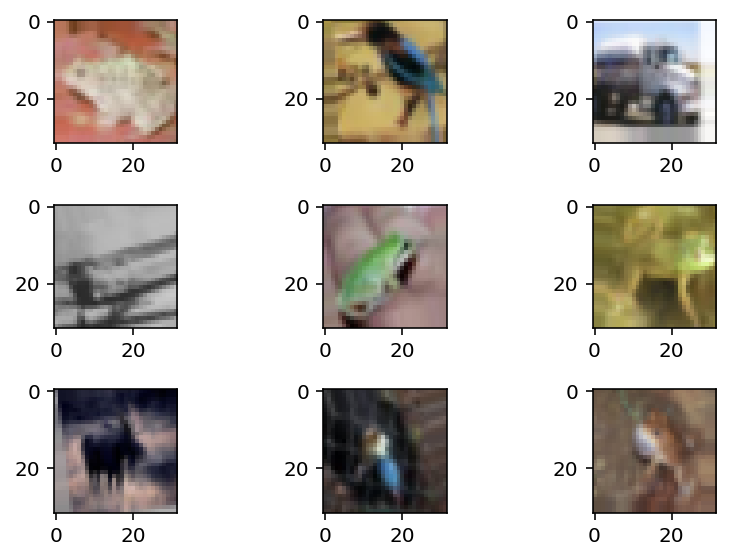

In [7]:
for x_batch, y_batch in train_datagen.flow(x_train, y_train, batch_size=9,seed=2020):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i])
    plt.tight_layout()
    break

## Define & Train the model

In [8]:
from utils.models import AttentionResNet164

In [ ]:
# define and compile model
model = AttentionResNet164(shape=(32,32,3), in_channel=32, kernel_size=5, n_classes=10)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

In [10]:
start = time.time()

batch_size = 32
epochs     = 150

# callbacks (Reference: https://github.com/qubvel/residual_attention_network/blob/master/train_cifar10.ipynb)
lr_reducer    = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=7, min_lr=10e-7, epsilon=0.01, verbose=1)
early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=1, restore_best_weights=True)


H = model.fit(train_datagen.flow(x_train, y_train, batch_size=batch_size),
            epochs           = epochs,
            steps_per_epoch  = len(x_train) // batch_size,
            validation_data  = val_datagen.flow(x_val, y_val, batch_size=batch_size),
            callbacks        = [lr_reducer, early_stopper])

end = time.time()
print("Total training time: {}.".format((end-start)/60))

Epoch 1/150
1250/1250 [==============================] - 296s 237ms/step - loss: 1.9373 - accuracy: 0.2918 - val_loss: 1.8133 - val_accuracy: 0.3722
Epoch 2/150
1250/1250 [==============================] - 288s 231ms/step - loss: 1.6405 - accuracy: 0.4020 - val_loss: 1.6671 - val_accuracy: 0.4258
Epoch 3/150
1250/1250 [==============================] - 287s 230ms/step - loss: 1.5012 - accuracy: 0.4619 - val_loss: 1.4165 - val_accuracy: 0.4921
Epoch 4/150
1250/1250 [==============================] - 286s 229ms/step - loss: 1.4026 - accuracy: 0.4949 - val_loss: 1.3688 - val_accuracy: 0.5091
Epoch 5/150
1250/1250 [==============================] - 283s 227ms/step - loss: 1.3203 - accuracy: 0.5249 - val_loss: 1.5514 - val_accuracy: 0.4733
Epoch 6/150
1250/1250 [==============================] - 283s 227ms/step - loss: 1.2395 - accuracy: 0.5560 - val_loss: 1.3368 - val_accuracy: 0.5480
Epoch 7/150
1250/1250 [==============================] - 284s 227ms/step - loss: 1.1750 - accuracy: 0.5786

KeyboardInterrupt: 

## Save model & plot training process

In [12]:
model_name = 'AttentionResNet164_cifar10'
model.save("./Models/"+model_name+".hdf5")

In [13]:
def plot_training(H, model_name):
    acc     = H.history['accuracy']
    val_acc = H.history['val_accuracy']
    loss    = H.history['loss']
    val_loss= H.history['val_loss']

    epochs = range(len(acc))

    fig, axes = plt.subplots(figsize=(10,4),ncols=2)

    axes[0].plot(epochs, acc, 'b',label='Train')
    axes[0].plot(epochs, val_acc, 'r',label='Validation')
    axes[0].set_title('Training and validation accuracy')
    axes[0].legend()


    axes[1].plot(epochs, loss, 'b')
    axes[1].plot(epochs, val_loss, 'r')
    axes[1].set_title('Training and validation loss')
    
    plt.tight_layout()
    plt.rcParams['savefig.dpi'] = 220
    plt.savefig('./Figures/TrainingProcess_'+model_name+'.png')
    
    # save the metrics of training process to a csv file
    hist_df = pd.DataFrame(H.history) 
    hist_df.to_csv('./Models/'+model_name+'_history.csv')

## Evaluation on the test set

In [15]:
test_result = model.evaluate(test_datagen.flow(x_test, y_test), 
                            steps=len(x_test)/batch_size)

313/313 [==============================] - 17s 53ms/step - loss: 0.3997 - accuracy: 0.8799


In [16]:
test_result

[0.39965924620628357, 0.8798999786376953]

In [21]:
y_predict = model.predict(x_test/255.)
y_predict

array([[2.3005452e-05, 2.8205061e-04, 1.0840198e-05, ..., 8.0617341e-05,
        2.7041064e-04, 2.8507342e-04],
       [3.2536047e-06, 3.6009331e-04, 2.8254923e-10, ..., 7.3267911e-12,
        9.9963474e-01, 1.9582294e-06],
       [2.2882300e-03, 2.9416138e-02, 3.7404174e-08, ..., 3.4756282e-09,
        9.4813710e-01, 2.0158425e-02],
       ...,
       [4.6749329e-07, 3.2881883e-07, 8.3872594e-04, ..., 6.6613931e-05,
        1.3849138e-06, 5.0997710e-07],
       [7.5964534e-05, 9.9988258e-01, 1.4636698e-06, ..., 5.6875655e-07,
        8.9796266e-08, 1.1154489e-05],
       [6.6506324e-08, 6.3315817e-08, 9.9250235e-07, ..., 9.6791953e-01,
        2.3039229e-08, 1.7638259e-08]], dtype=float32)

In [22]:
# compute and plot confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues,save_path=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    fig, axes = plt.subplots(figsize=(12,6),ncols=2)
    
    im = axes[0].imshow(cm, interpolation='nearest', cmap=cmap)
    axes[0].set_title('Confusion matrix without normalization')
    fig.colorbar(im,ax=axes[0],shrink=0.75)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0].text(j, i, cm[i, j],horizontalalignment="center", fontsize=8,
                         color="white" if cm[i, j] > thresh else "black")

    # normalized
    cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_n = np.around(cm_n,decimals=2)

    im_n = axes[1].imshow(cm_n, interpolation='nearest', cmap=cmap)
    axes[1].set_title('Normalized confusion matrix')
    fig.colorbar(im_n,ax=axes[1],shrink=0.75)

    thresh = cm_n.max() / 2.
    for i in range(cm_n.shape[0]):
        for j in range(cm_n.shape[1]):
            axes[1].text(j, i, cm_n[i, j],horizontalalignment="center", fontsize=8,
                         color="white" if cm_n[i, j] > thresh else "black")

    tick_marks = np.arange(len(classes))
    for ax in axes:
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(classes, rotation=45)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(classes, rotation=45)
        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')

    plt.tight_layout()
    
    if save_path is not None:
        plt.rcParams['savefig.dpi'] = 220
        plt.savefig('./Figures/confusion_matrix_'+save_path+'.png')

    
    print('Confusion matrix, without normalization')
    # print(cm)
    print("Normalized confusion matrix")
    # print(cm_n)
    plt.show()

In [23]:
y_predict.argmax(axis=-1)

array([3, 8, 8, ..., 5, 1, 7])

Confusion matrix, without normalization
Normalized confusion matrix


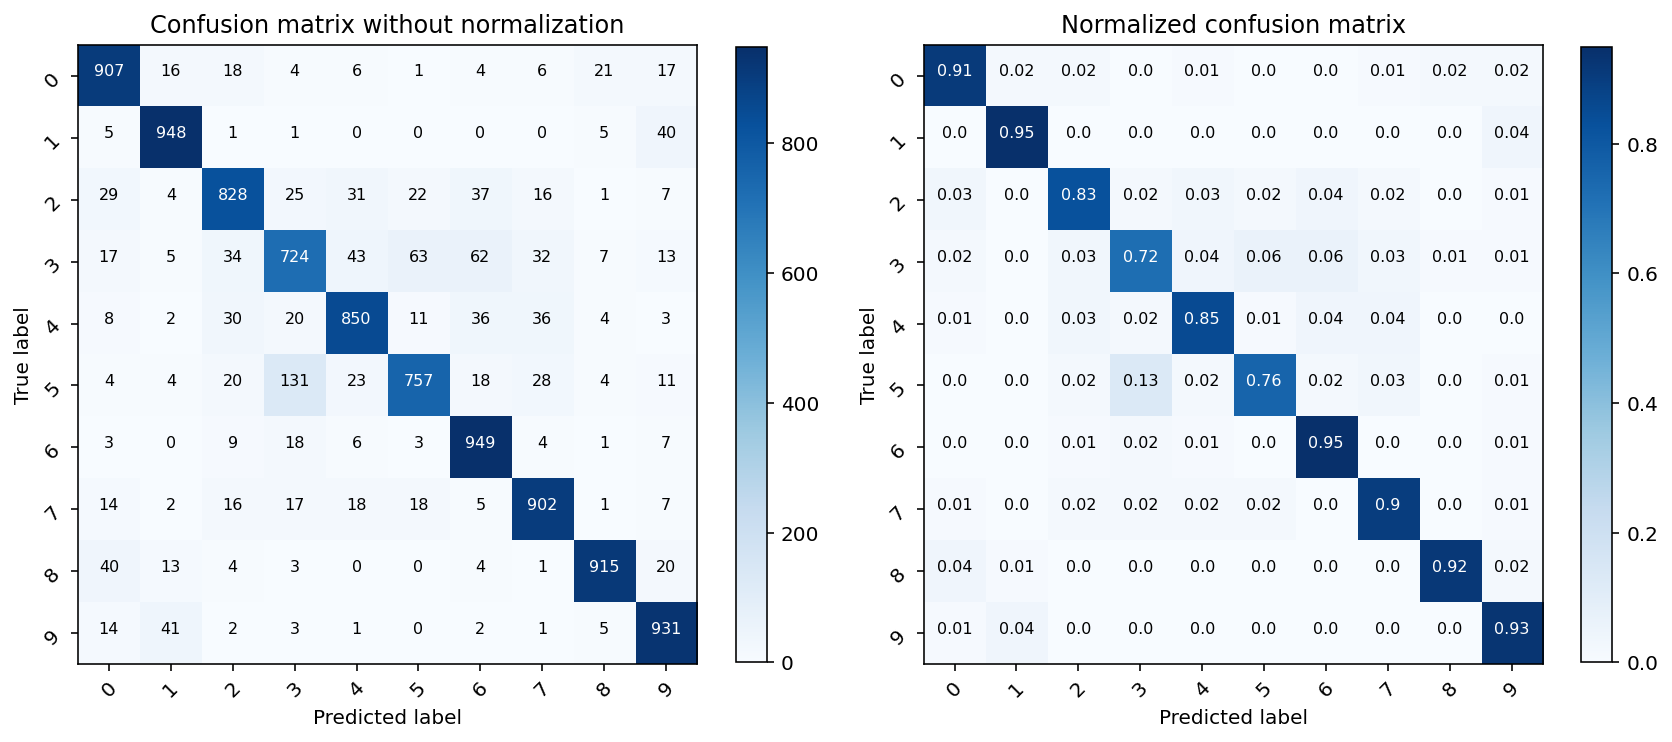

In [24]:
class_labels=['0','1','2','3','4','5','6','7','8','9']

cnf_matrix = confusion_matrix(y_test.argmax(axis=-1),y_predict.argmax(axis=-1)) 
plot_confusion_matrix(cnf_matrix, 
                      classes=class_labels, 
                      cmap=plt.cm.Blues,
                      save_path=model_name)